In [60]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import os
import matplotlib.patches as patches
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tensorflow.keras import regularizers
from keras.regularizers import l1

SEED = 42
keras.utils.set_random_seed(SEED)

In [2]:
# Abre el archivo JSON en modo lectura
with open('dish_dict.json', 'r') as file:
    # Carga los datos desde el archivo JSON
    dish_dict = json.load(file)

with open('food_categories_dict.json', 'r') as file:
    # Carga los datos desde el archivo JSON
    food_categories_dict = json.load(file)
    
with open('hierarchy_dict.json', 'r') as file:
# Carga los datos desde el archivo JSON
    hierarchy_dict = json.load(file)

In [105]:
# Path de las imágenes y anotaciones
path_images = os.listdir("images/") 

data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')

y_train_category = data_train['food_category']
y_train_dish = data_train['dish']


In [135]:
caso='1'
output_results = f"Results/{caso}/"
os.makedirs(output_results, exist_ok=True)

In [133]:
def recognize(dict,element):
    for rr in dict.keys():
        d=dict[rr]
        for jj in range(len(d)):
            d_e=d[str(jj)]
            if element == d_e:
                return [rr]

def rec(dict,element):
    for rr in dict.keys():
        if element == dict[rr]:
            return(rr)

def extract_img(dir,size):
    Imag = keras.utils.load_img(dir)
    if size!=0:
        Imag = Imag.resize((size, size))
    Imag = keras.utils.img_to_array(Imag)
    return(Imag)

def plot_history(history,ac1,ac2): # Función para visualizar las métricas de entrenamiento y validación
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  sns.lineplot

  #training
  sns.lineplot(history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(history.history[f"{ac1}_accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(history.history[f"{ac2}_accuracy"], ax = axes[2], label="Training Accuracy")

  # Validacion
  sns.lineplot(history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(history.history[f"val_{ac1}_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(history.history[f"val_{ac2}_accuracy"], ax = axes[2], label="Validation Accuracy")


  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title(f"{ac1} Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title(f"{ac2} Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Accuracy")

  plt.tight_layout()
  fig.savefig(os.path.join(output_results, "Plot_history.png"))
  plt.show()

In [5]:
X_train=[]
X_test=[]
y_test_category=[]
y_test_dish=[]

image_size = 64

for ii,i in enumerate([data_train,data_test]):
    print(ii)
    path=i['path']

    for j in path:
        if ii==0:
            X_train.append(extract_img(j,image_size))
        elif ii==1:
            X_test.append(extract_img(j,image_size))

            dish=j.split('/')[1]
            category=recognize(hierarchy_dict, dish)[0]
            dish=rec(dish_dict,dish)
            category=rec(food_categories_dict,category)
            y_test_category.append(category)
            y_test_dish.append(dish)

0
1


In [6]:
X_train, X_val, y_train_category, y_val_category, y_train_dish, y_val_dish = train_test_split(np.array(X_train), y_train_category, y_train_dish, test_size=0.3, random_state=SEED)
X_test=np.array(X_test)
y_test_category=pd.DataFrame(y_test_category)[0]
y_test_dish=pd.DataFrame(y_test_dish)[0]

In [136]:
print(f'Shape images: {X_train.shape}')
print(f'X_train: {len(X_train)}')
print(f'X_val: {len(X_val)}')
print(f'Y_train_category: {y_train_category.shape[0]}')
print(f'Y_train_dish: {y_train_dish.shape[0]}')
print(f'Y_val_cateogory: {y_val_category.shape[0]}')
print(f'Y_val_dish: {y_val_dish.shape[0]}')
print(f'Y_test_cateogory: {y_test_category.shape[0]}')
print(f'Y_test_dish: {y_test_dish.shape[0]}')

Shape images: (53025, 64, 64, 3)
X_train: 53025
X_val: 22725
Y_train_category: 75750
Y_train_dish: 75750
Y_val_cateogory: 22725
Y_val_dish: 22725
Y_test_cateogory: 25250
Y_test_dish: 25250


In [15]:
num_classes_dish=len(set(y_train_dish))
num_classes_category=len(set(y_train_category))

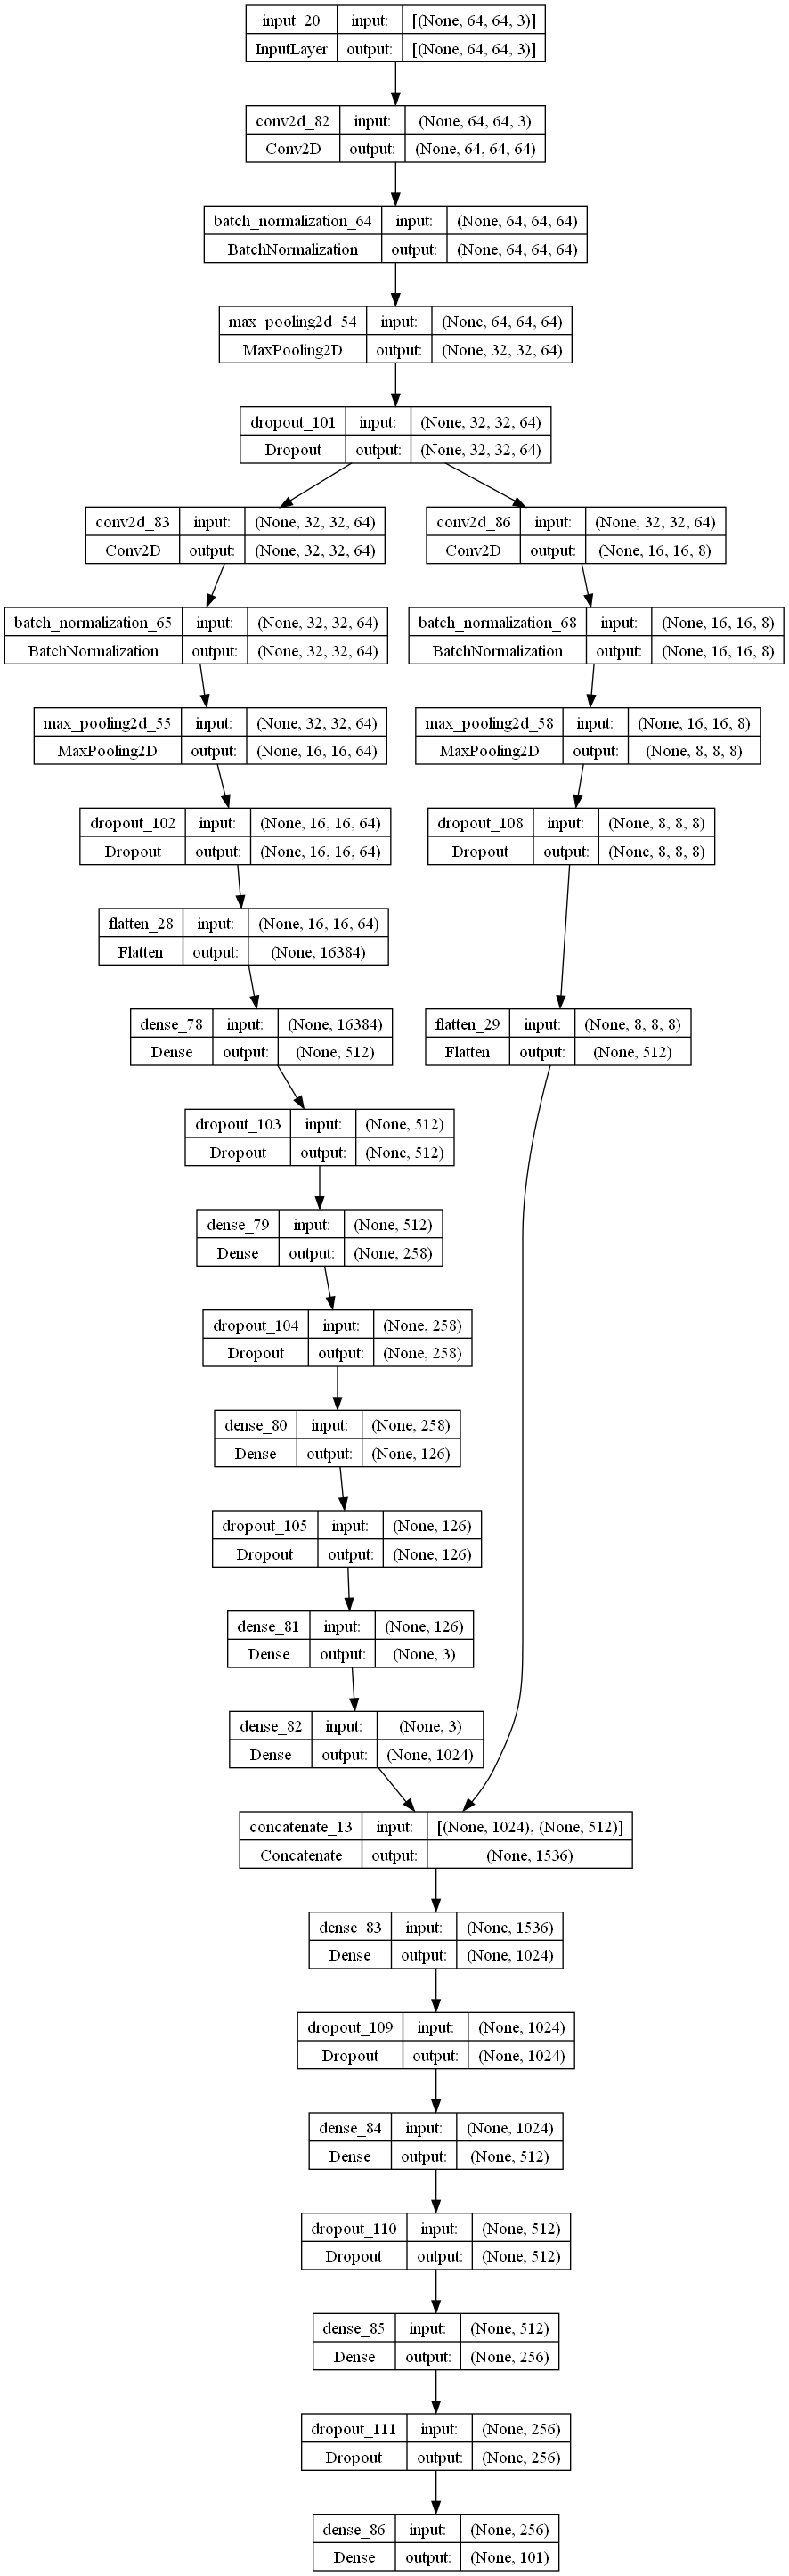

In [109]:
def get_model(X, n1, n2):
    #Capa de Input
    inputs = tf.keras.layers.Input(shape = X.shape[1:])

    #Primer Downsample
    conv_1 = tf.keras.layers.Conv2D(64, kernel_size = (4, 4), padding = "same", strides = 1, activation='relu')(inputs)
    conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
    conv_1 = tf.keras.layers.MaxPooling2D(pool_size = 2)(conv_1)
    conv_1 = tf.keras.layers.Dropout(0.2)(conv_1)

    conv_n1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation='relu')(conv_1)
    conv_n1 = tf.keras.layers.BatchNormalization()(conv_n1)
    conv_n1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv_n1)
    conv_n1 = tf.keras.layers.Dropout(0.2)(conv_n1)
    flatten_n1 = tf.keras.layers.Flatten()(conv_n1)
    flatten_n1 = keras.layers.Dense(512, activation='relu')(flatten_n1)
    flatten_n1 = tf.keras.layers.Dropout(0.2)(flatten_n1) 
    flatten_n1 = keras.layers.Dense(258, activation='relu')(flatten_n1)
    flatten_n1 = tf.keras.layers.Dropout(0.2)(flatten_n1) 
    flatten_n1 = keras.layers.Dense(126, activation='relu')(flatten_n1)
    flatten_n1 = tf.keras.layers.Dropout(0.2)(flatten_n1) 
    superclass_output = keras.layers.Dense(n1, activation='softmax')(flatten_n1)

    conv_n2 = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), padding = "same", strides = (2,2), activation='relu')(conv_1)
    conv_n2 = tf.keras.layers.BatchNormalization()(conv_n2)
    conv_n2 = tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2)(conv_n2)
    conv_n2 = tf.keras.layers.Dropout(0.2)(conv_n2)

    conv_n2 = tf.keras.layers.Conv2D(16, kernel_size = (3, 3), padding = "same", strides = (2,2), activation='relu')(conv_1)
    conv_n2 = tf.keras.layers.BatchNormalization()(conv_n2)
    conv_n2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2)(conv_n2)
    conv_n2 = tf.keras.layers.Dropout(0.2)(conv_n2)

    conv_n2 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), padding = "same", strides = (2,2), activation='relu')(conv_1)
    conv_n2 = tf.keras.layers.BatchNormalization()(conv_n2)
    conv_n2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2)(conv_n2)
    conv_n2 = tf.keras.layers.Dropout(0.2)(conv_n2)

    flatten_n2 = tf.keras.layers.Flatten()(conv_n2)

    
    flatten_n22 = keras.layers.Dense(1024, activation='relu')(superclass_output)

    flatten_n2 = tf.keras.layers.Concatenate()([flatten_n22, flatten_n2])
    flatten_n2 = keras.layers.Dense(1024, activation='relu')(flatten_n2)
    flatten_n2 = tf.keras.layers.Dropout(0.2)(flatten_n2) 
    flatten_n2 = keras.layers.Dense(512, activation='relu')(flatten_n2)
    flatten_n2 = tf.keras.layers.Dropout(0.2)(flatten_n2) 
    flatten_n2 = keras.layers.Dense(256, activation='relu')(flatten_n2)
    flatten_n2 = tf.keras.layers.Dropout(0.2)(flatten_n2)
    
    subclass_output = keras.layers.Dense(n2, activation='softmax')(flatten_n2)

    m = keras.Model(inputs=inputs, outputs=[superclass_output, subclass_output])
    return m

model = get_model(X_train, num_classes_category, num_classes_dish)

tf.keras.utils.plot_model(model,to_file=os.path.join(output_results, 'model.png'), show_shapes = True)


In [57]:
# Hiperparámetros
patience= 10
learning_rate=0.001
batch_size = 128 ##256#128
ep = 100

my_callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=patience,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)]
opt=tf.keras.optimizers.AdamW(learning_rate=learning_rate,weight_decay=0.004,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False, clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,name="AdamW")
loss=tf.keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']

model.compile(optimizer=opt,
            loss=loss,
            metrics=metrics)

model.summary()



Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_77 (Conv2D)          (None, 64, 64, 64)           3136      ['input_19[0][0]']            
                                                                                                  
 batch_normalization_59 (Ba  (None, 64, 64, 64)           256       ['conv2d_77[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_49 (MaxPooli  (None, 32, 32, 64)           0         ['batch_normalization_5

In [58]:
model_history = model.fit(X_train, [y_train_category, y_train_dish], batch_size=batch_size, epochs=ep,
                        callbacks=my_callbacks,
                        validation_data=(X_val, [y_val_category, y_val_dish])
                        )

model.save(os.path.join(output_results, 'kaggle.keras'))

Epoch 1/100
415/415 [==============================] - 336s 807ms/step - loss: 5.1416 - dense_72_loss: 0.7249 - dense_77_loss: 4.4167 - dense_72_accuracy: 0.7350 - dense_77_accuracy: 0.0393 - val_loss: 4.7977 - val_dense_72_loss: 0.6277 - val_dense_77_loss: 4.1701 - val_dense_72_accuracy: 0.7548 - val_dense_77_accuracy: 0.0705
Epoch 2/100
415/415 [==============================] - 271s 652ms/step - loss: 4.6985 - dense_72_loss: 0.5971 - dense_77_loss: 4.1014 - dense_72_accuracy: 0.7572 - dense_77_accuracy: 0.0798 - val_loss: 4.7207 - val_dense_72_loss: 0.6136 - val_dense_77_loss: 4.1071 - val_dense_72_accuracy: 0.7570 - val_dense_77_accuracy: 0.0817
Epoch 3/100
415/415 [==============================] - 265s 639ms/step - loss: 4.5060 - dense_72_loss: 0.5648 - dense_77_loss: 3.9412 - dense_72_accuracy: 0.7684 - dense_77_accuracy: 0.1047 - val_loss: 4.7296 - val_dense_72_loss: 0.6417 - val_dense_77_loss: 4.0879 - val_dense_72_accuracy: 0.7126 - val_dense_77_accuracy: 0.0869
Epoch 4/100
4

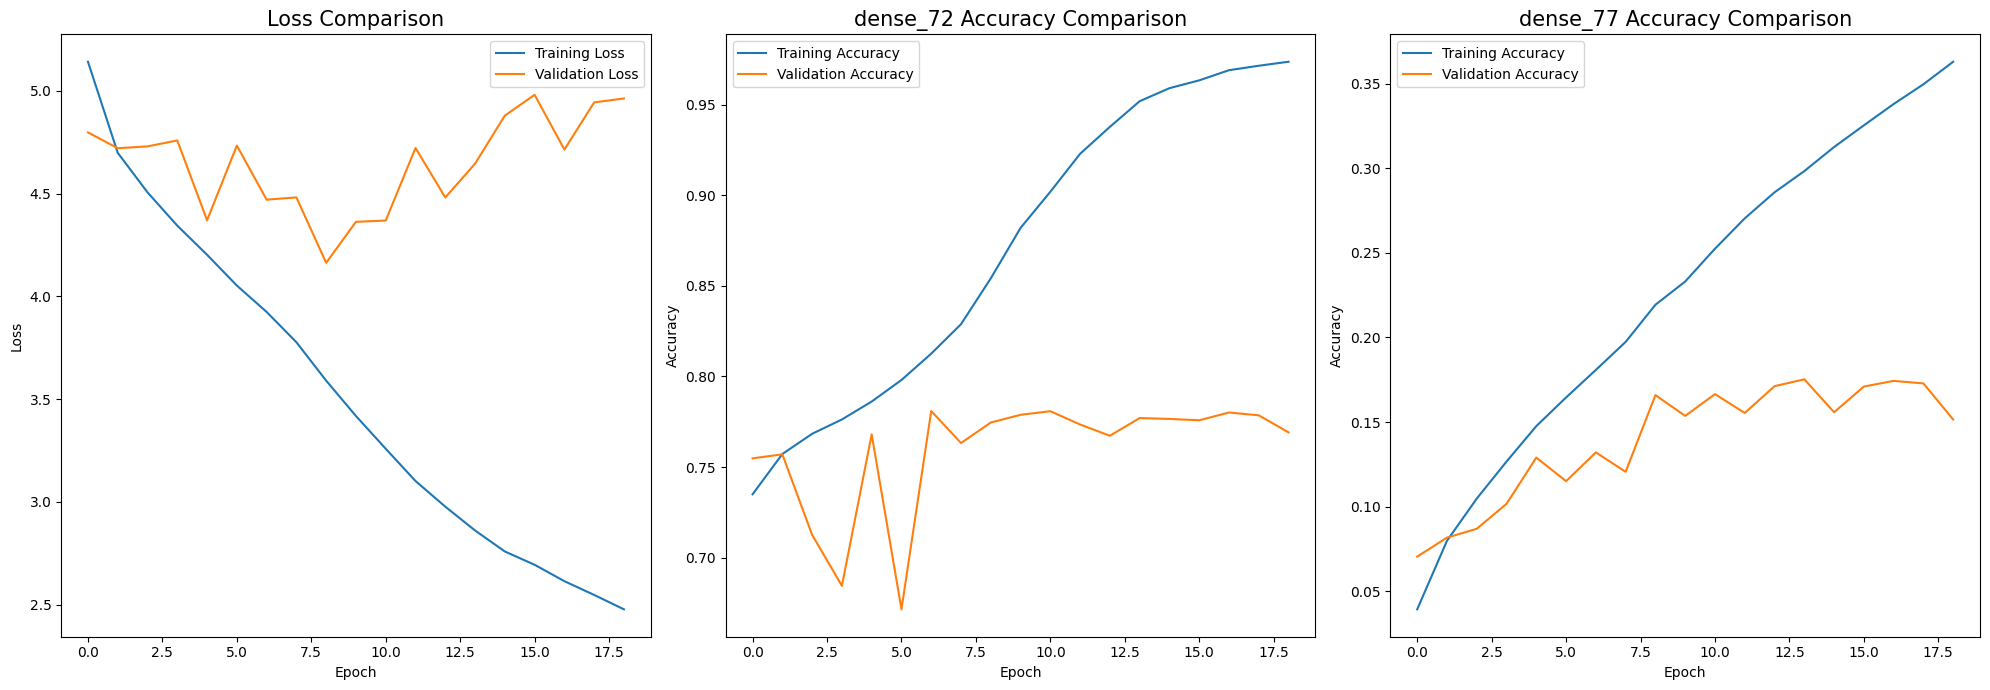

In [134]:
plot_history(model_history,'dense_72','dense_77') 

In [137]:
y_test_category=y_test_category.astype('int64')
y_test_dish=y_test_dish.astype('int64')

In [99]:
prob_pred = model.predict(X_test)
num_pred_category= np.argmax(prob_pred[0], axis=1)
num_pred_dish= np.argmax(prob_pred[1], axis=1)
test_acc = model.evaluate(X_test, [y_test_category, y_test_dish],verbose=1)

print('\nTest loss:', test_acc[0])
print('\nTest category loss:', test_acc[1])
print('\nTest dish loss:', test_acc[2])
print('\nTest category accuracy:', test_acc[3])
print('\nTest dish accuracy:', test_acc[4])

790/790 [==============================] - 24s 30ms/step - loss: 4.1921 - dense_72_loss: 0.5742 - dense_77_loss: 3.6179 - dense_72_accuracy: 0.7705 - dense_77_accuracy: 0.1603

Test loss: 4.19211483001709

Test category loss: 0.5741786360740662

Test dish loss: 3.617936849594116

Test category accuracy: 0.7704554200172424

Test dish accuracy: 0.1603168249130249


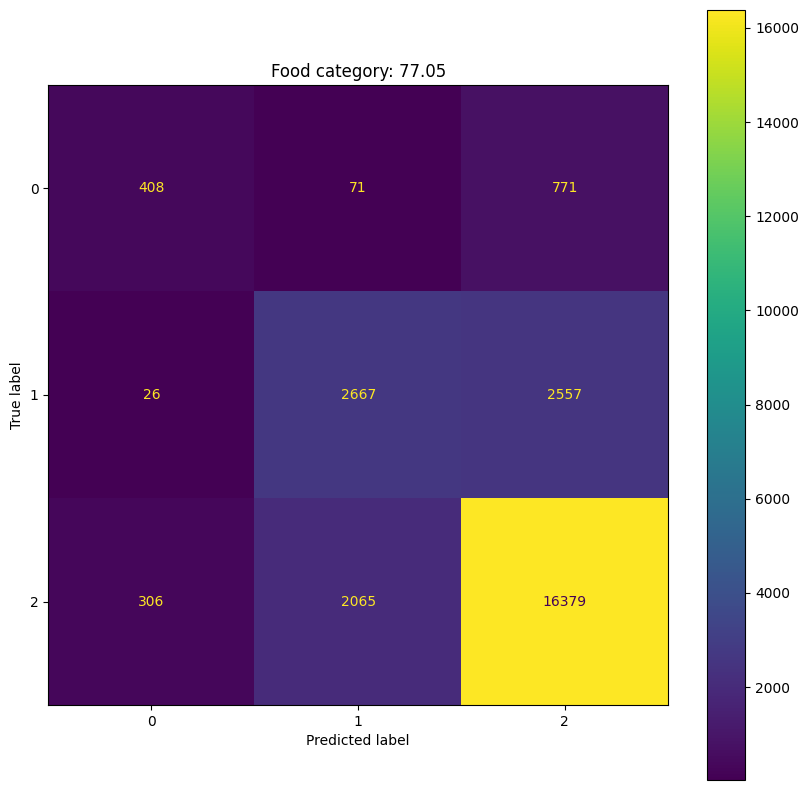

In [108]:
# Graficando Matriz de confusion
cm_ann = confusion_matrix(y_test_category, num_pred_category)
disp_ann  = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=set(y_train_category))

fig, axes = plt.subplots(figsize=(10,10))

disp_ann.plot(ax=axes)
axes.set_title(f'Food category: {round(test_acc[3]*100,2)}')
plt.show()

fig.savefig(os.path.join(output_results, 'category.png'))
#plt.close(fig)

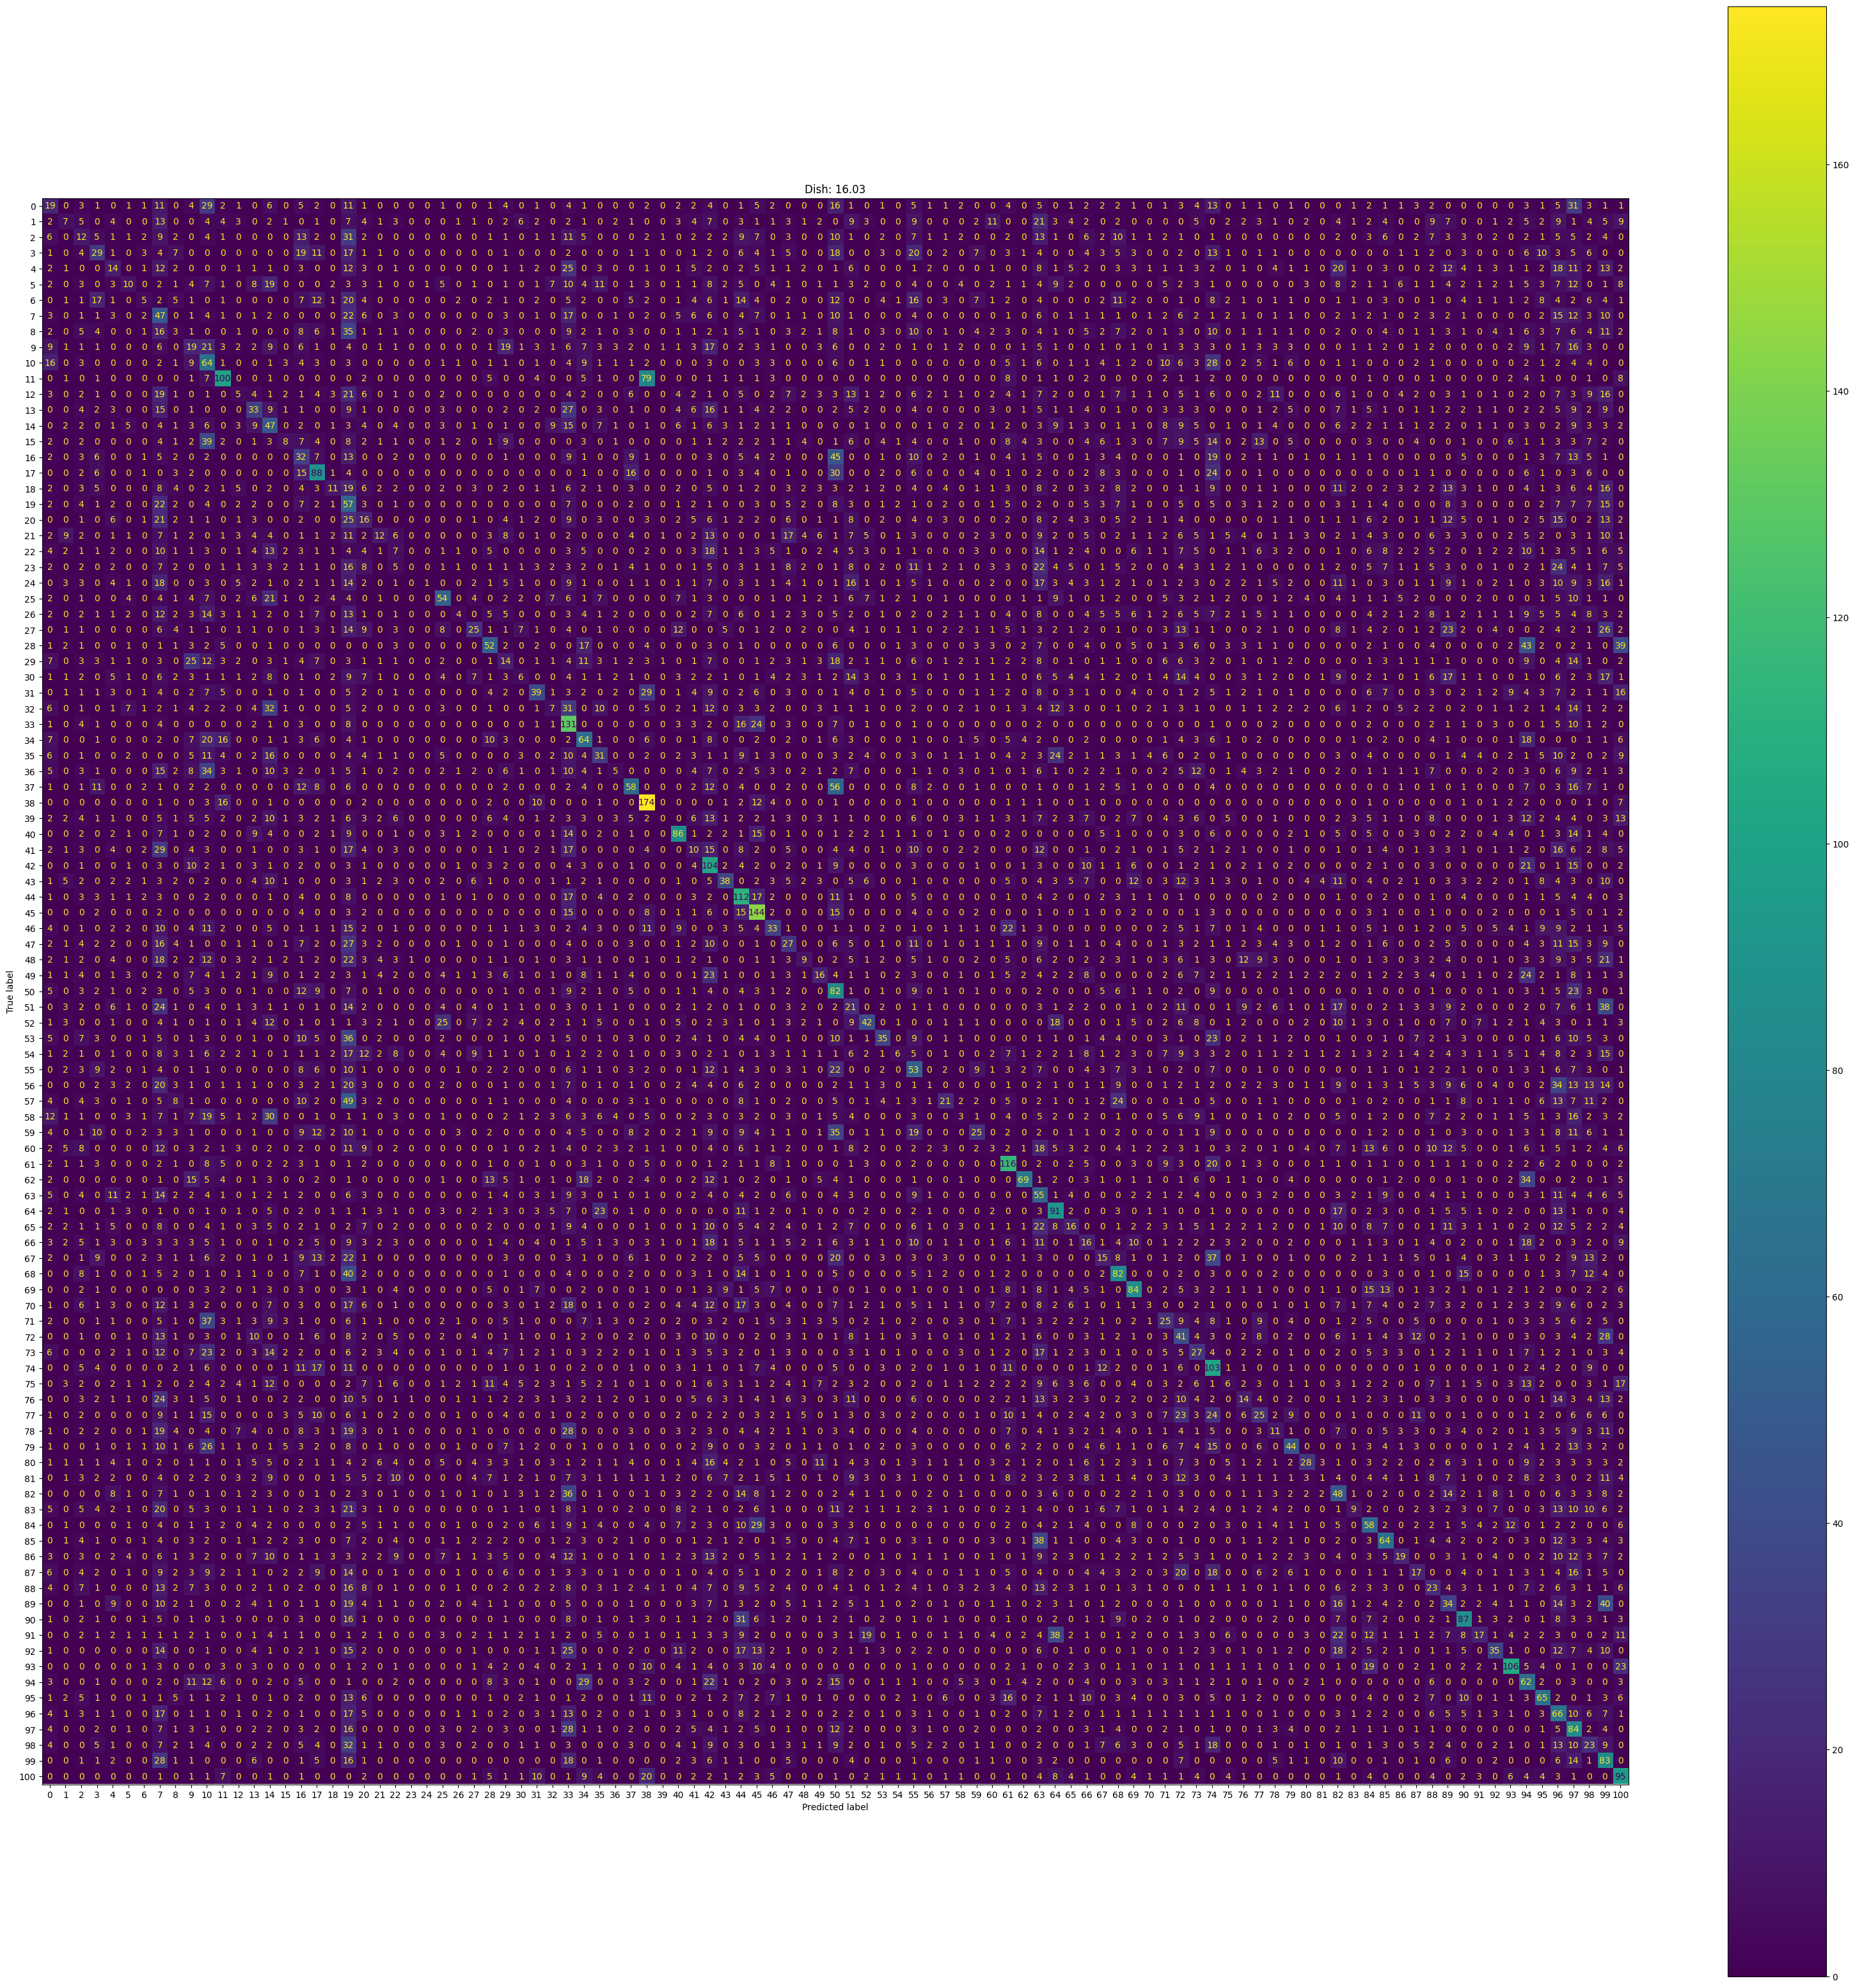

In [107]:
# Graficando Matriz de confusion
cm_ann = confusion_matrix(y_test_dish, num_pred_dish)
disp_ann  = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=set(y_train_dish))

fig, axes = plt.subplots(figsize=(40,40))

disp_ann.plot(ax=axes)
axes.set_title(f'Dish: {round(test_acc[4]*100,2)}')
plt.show()
fig.savefig(os.path.join(output_results, 'dish.png'))
#plt.close(fig)

In [112]:
num_pred_category=num_pred_category.astype('str')
num_pred_dish=num_pred_dish.astype('str')

(array([2, 2, 2, ..., 2, 2, 0], dtype=int64),
 array([94, 48, 18, ..., 97, 68, 11], dtype=int64))

In [125]:
y=[]
for i in range(num_pred_category.shape[0]):
    y.append( f'{num_pred_category[i]} {num_pred_dish[i]}' )
    
data_test['classes']=y
data_test.to_csv(os.path.join(output_results, 'submission_file.csv'))
data_test

,path,classes
0,images/caprese_salad/820512.jpg,2 94
1,images/hamburger/2062556.jpg,2 48
2,images/lasagna/2381454.jpg,2 18
3,images/ceviche/1995.jpg,2 82
4,images/poutine/892377.jpg,1 8
...,...,...
25245,images/ravioli/2087725.jpg,2 42
25246,images/ice_cream/504131.jpg,2 69
25247,images/cannoli/1187751.jpg,2 97
25248,images/pancakes/477236.jpg,2 68
